# Summary
In this notebook, we explore the isotropickernel and its relationship with vanadium data

In [ ]:
cd ~/notebooks/mcvine/dev/kernels/

In [7]:
import os, numpy as np
import mcni
from mcni.utils import conversion
from mccomponents import mccomponentsbp
import histogram.hdf as hh, histogram as H

In [12]:
from matplotlib import pyplot as plt
%matplotlib notebook

# Simulation using IsotropicKernel

In [19]:
kernel = mccomponentsbp.IsotropicKernel(1., 1.)

In [41]:
vi = np.array((0,0,8000))
ki =conversion.v2k(np.linalg.norm(vi))
print ki

12.706039537


In [39]:
N = 10000
Qs = []; vfs = []; probs = []
for i in range(N):
    n = mcni.neutron(v=vi)
    kernel.scatter(n)
    vf = np.array(n.state.velocity)
    vdiff = vi - vf
    vdiff_mag = np.linalg.norm(vdiff)
    Q = conversion.v2k(vdiff_mag)
    p = n.probability
    Qs.append(Q); vfs.append(vf); probs.append(p)
    continue

## histogram

In [49]:
dQ = 0.1

In [42]:
hist, Qbb = np.histogram(Qs, weights=probs, bins=np.arange(0, 2*ki, dQ))

In [43]:
Qcenters = (Qbb[1:] + Qbb[:-1])/2

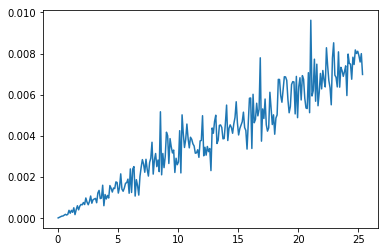

In [46]:
plt.figure()
plt.plot(Qcenters, hist/N)

We can see that the intensity is linear with Q. This seems to be against what we usually see when we look at vanadium data, which has a flat I(Q) curve. The reason is we have not normalize the data with solid angle. In the following let us first prove that this linear correlation is correct.

## derivation

Assuming an isotropic cross section, then we have
\begin{equation}
\frac{d \sigma}{d\Omega} = \frac{\sigma}{4\pi}
\end{equation}

For simplicity, let us assume $\sigma=1$, then

\begin{align}
dI &= \frac{d\sigma}{d\Omega} d\Omega = \frac{\sigma}{4\pi} d\Omega  = \frac{d\Omega}{4\pi} \\
   &= \sin(\theta) d\theta d\phi / {4\pi}
\end{align}

integrate over $\phi$

\begin{align}
dI &= \frac{1}{2} \sin(\theta) d\theta 
\end{align}


Because

\begin{align}
Q^2 &= k_i^2 + k_f^2 - 2 k_i k_f \cos(\theta) \\
2QdQ &= 2 k_i k_f \sin(\theta) d\theta \\
\sin(\theta) d\theta &= \frac{Q dQ}{ k_i k_f }
\end{align}

we get
\begin{align}
dI &= \frac{1}{2} \frac{Q}{k_i k_f} dQ \\
dI/dQ &= \frac{1}{2} \frac{Q}{k_i k_f}
\end{align}

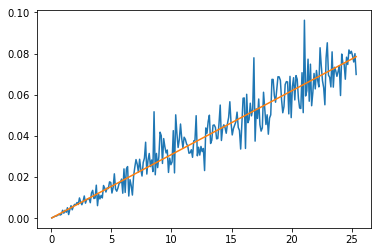

In [50]:
plt.figure()
plt.plot(Qcenters, hist/N/dQ)
plt.plot(Qcenters, 1./2*Qcenters/ki/ki)

We can see the agreement between the isotropic kernel and the quick analytical model

# consider detector coverage
z: beam; y: vertical up

In [54]:
vfs = np.array(vfs)
vfx, vfy, vfz = vfs.view().T

In [55]:
angle_in_plane = np.rad2deg( np.arctan2(vfx, vfz) )

In [57]:
vf_mag = np.linalg.norm(vi)

In [58]:
angle_out_of_plane = np.rad2deg(np.arcsin(vfy/vf_mag))

In [28]:
# plt.figure()
# plt.plot(angle_out_of_plane, '.')

Approximate condition for ARCS

In [59]:
condition = (angle_in_plane>-28) * (angle_in_plane<135) * (angle_out_of_plane>-27) * (angle_out_of_plane<26)

In [63]:
Qs = np.array(Qs)
probs = np.array(probs)

In [64]:
hist, Qbb = np.histogram(Qs[condition], weights=probs[condition], bins=np.arange(0, 2*ki, dQ))

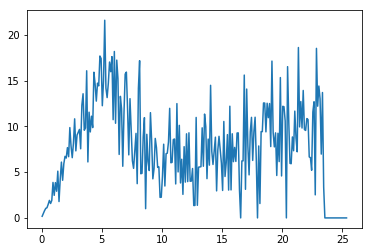

In [65]:
plt.figure()
plt.plot(Qcenters, hist)

Again, please note that this intensity is not yet normalized by solid angle. You see it is not a linear correlation, because the solid angle coverage is limited by the detector system.

# Vanadium data
For reference, here we reduce a vanadium data set and look at I(Q)

In [69]:
!wget https://www.dropbox.com/s/tbh4jcwiags410d/ARCS_V_annulus.nxs?dl=1 -O ARCS_V_annulus.nxs

--2018-04-23 13:23:46--  https://www.dropbox.com/s/tbh4jcwiags410d/ARCS_V_annulus.nxs?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/PxjRfZnNPVrHyqzwKosNixKLTkhU6HcPL9XoCm5MkvQK64kxMmxjEno8vjsNetM0/file?dl=1 [following]
--2018-04-23 13:23:46--  https://dl.dropboxusercontent.com/content_link/PxjRfZnNPVrHyqzwKosNixKLTkhU6HcPL9XoCm5MkvQK64kxMmxjEno8vjsNetM0/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601f:6::a27d:906
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.9.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 313012199 (299M) [application/binary]
Saving to: ‘ARCS_V_annulus.nxs’

100%[======================================>] 313,012,199 41.3MB/s   in 

In [74]:
from mantid.simpleapi import DgsReduction, LoadInstrument, Load, MoveInstrumentComponent, GetEiT0atSNS, GetEi, SolidAngle
from mantid import mtd

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mantid/kernel/__init__.py:14: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  from ._kernel import *
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mantid/kernel/__init__.py:14: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
  from ._kernel import *


Use Mantid to reduce. We use "SolidAngle" to calculate the solid angle of each pixel, and use that to do solid angle normalization. Usually this is done with a vanadium dataset, and that is why we called the solidangle workspace "van" below.

In [75]:
nxsfile = "./ARCS_V_annulus.nxs"
eaxis = "-100,1.,100."
ws, mons = Load(nxsfile, LoadMonitors=True)
Eguess=ws.getRun()['EnergyRequest'].getStatistics().mean
Efixed,_p,_i,T0=GetEi(InputWorkspace=mons,Monitor1Spec=1,Monitor2Spec=2,EnergyEstimate=Eguess,FixEi=False)
ws = Load(nxsfile)
print Efixed, T0
van = SolidAngle(ws)
DgsReduction(
    SampleInputWorkspace=ws,
    IncidentEnergyGuess=Efixed,
    UseIncidentEnergyGuess=True,
    TimeZeroGuess = T0,
    OutputWorkspace='reduced',
    EnergyTransferRange=eaxis,
    IncidentBeamNormalisation="ByCurrent",
    DetectorVanadiumInputWorkspace=van,
    UseProcessedDetVan=True
    )
reduced = mtd['reduced']

116.377816764 15.5069138739


Reduce to I(Q,E)

In [93]:
from mcvine.instruments.ARCS.applications.nxs import getSqeHistogramFromMantidWS
getSqeHistogramFromMantidWS(reduced, 'v-iqe.h5', qaxis=(0.,0.1,13.))

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcvine/instruments/ARCS/applications/nxs.py:98: RuntimeWarning:

invalid value encountered in divide

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcvine/instruments/ARCS/applications/nxs.py:99: RuntimeWarning:

invalid value encountered in divide



In [102]:
import histogram.hdf as hh
viqe = hh.load("v-iqe.h5")

plot z in (0, 55.2280640897)


<IPython.core.display.Javascript object>


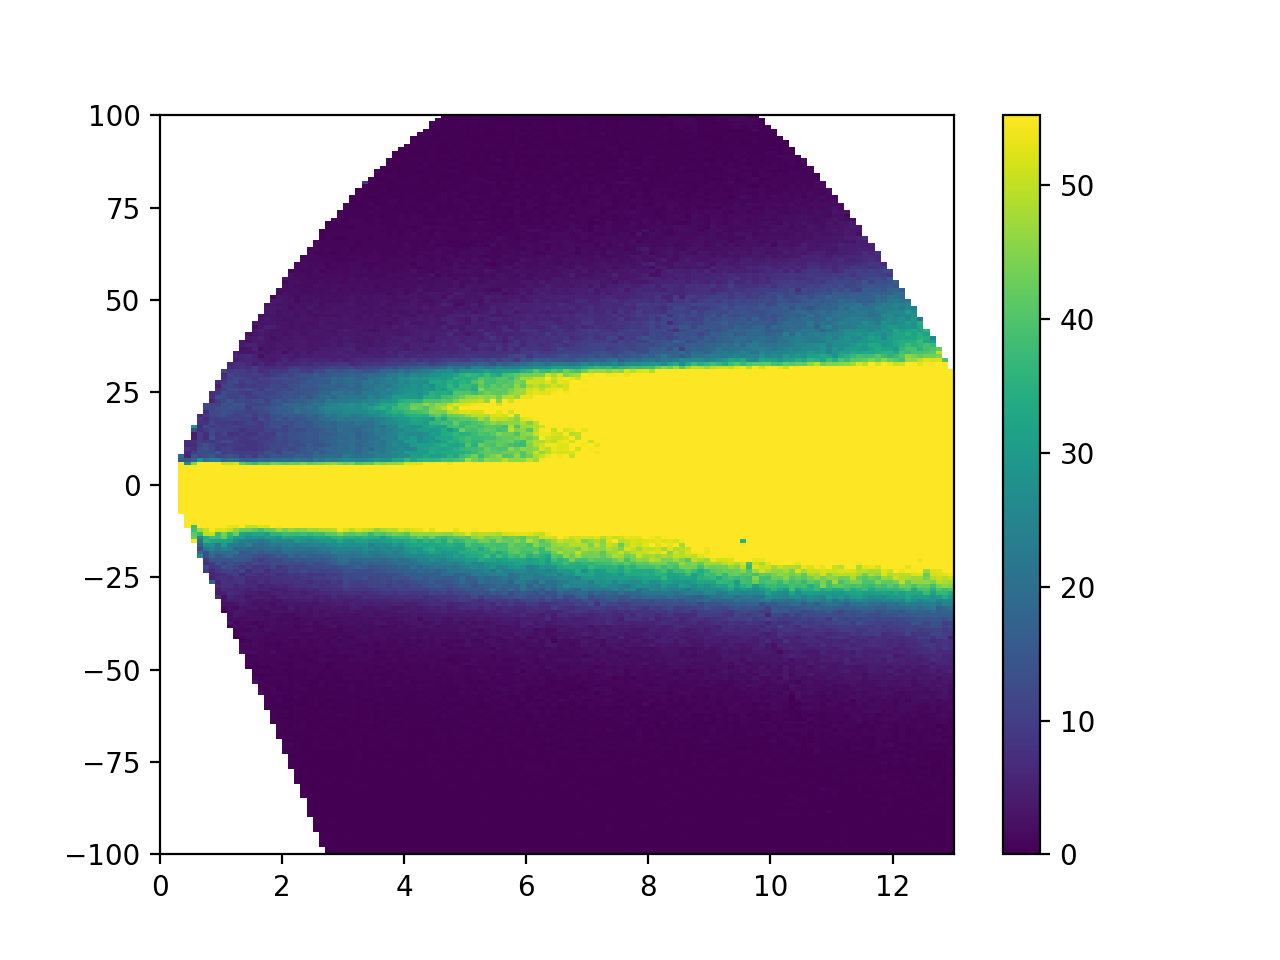

In [103]:
import histogram as H
H.plot(viqe, min=0)

In [104]:
viqe2 = viqe.copy()
I = viqe2.I
I[I!=I] = 0
viq = viqe2[(), (-99, 99)].sum('E')

<IPython.core.display.Javascript object>


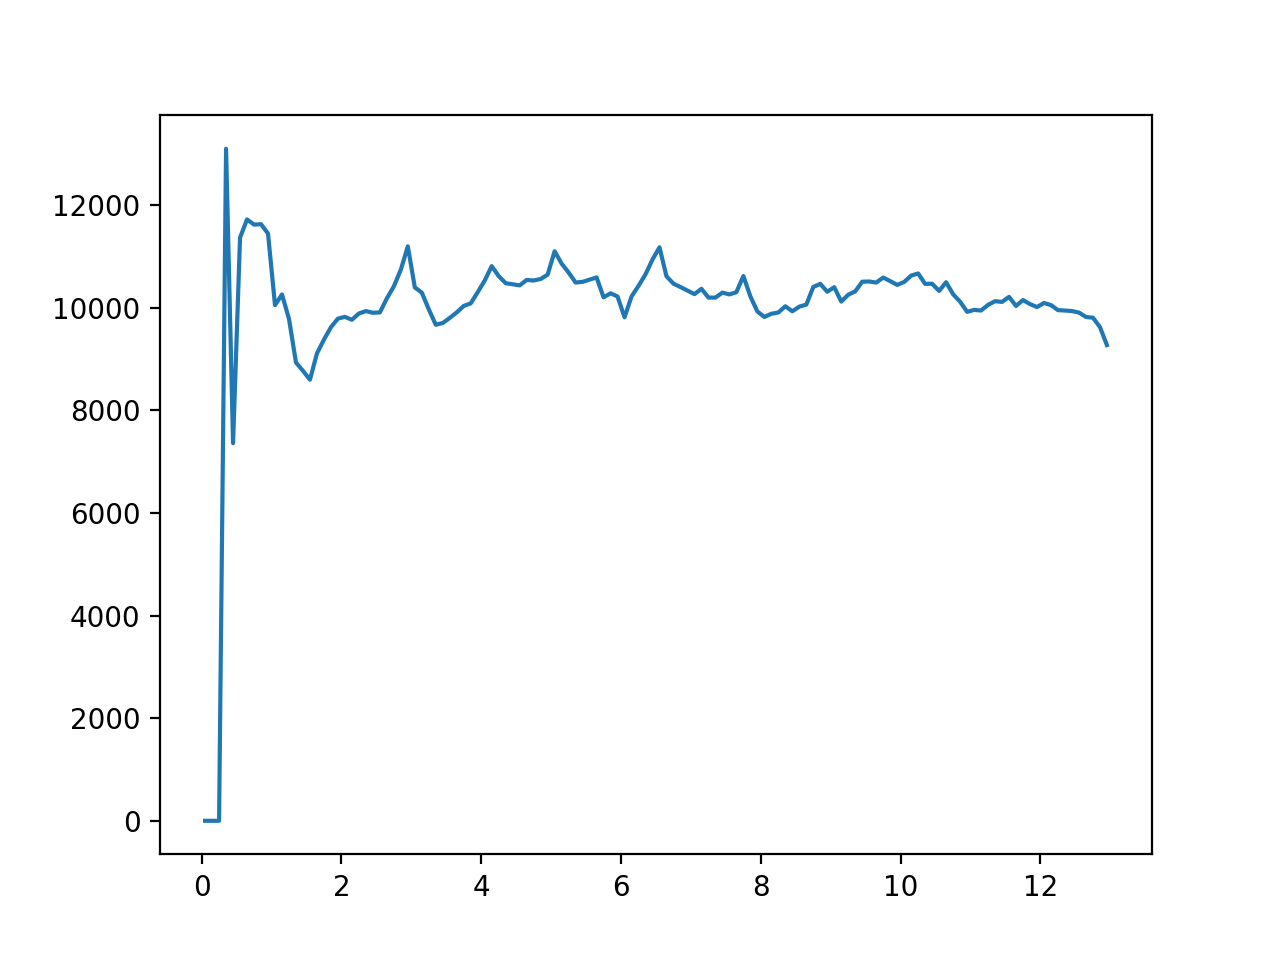

In [105]:
%matplotlib notebook
plt.figure()
plt.plot(viq.Q, viq.I)

Here we see a mostly flat I(Q) curve as we expected.

# Use Isotropic Kernel with ARCS

A simulation of a sphere-shell sample with an isotropic kernel measured at ARCS.
The I(Q,E) spectrum was saved. Here we just examine it. 

In [8]:
iqe = hh.load('./ARCS_IsotropicKernel-iqe.h5')

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


plot z in (0, 1e-05)


/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/histogram/data_plotter.py:352: RuntimeWarning: invalid value encountered in less
  negative_median = N.median( z[ z<0 ] )
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/histogram/data_plotter.py:334: RuntimeWarning: invalid value encountered in greater
  positive_median = N.median( z[ z>0 ] )


<IPython.core.display.Javascript object>


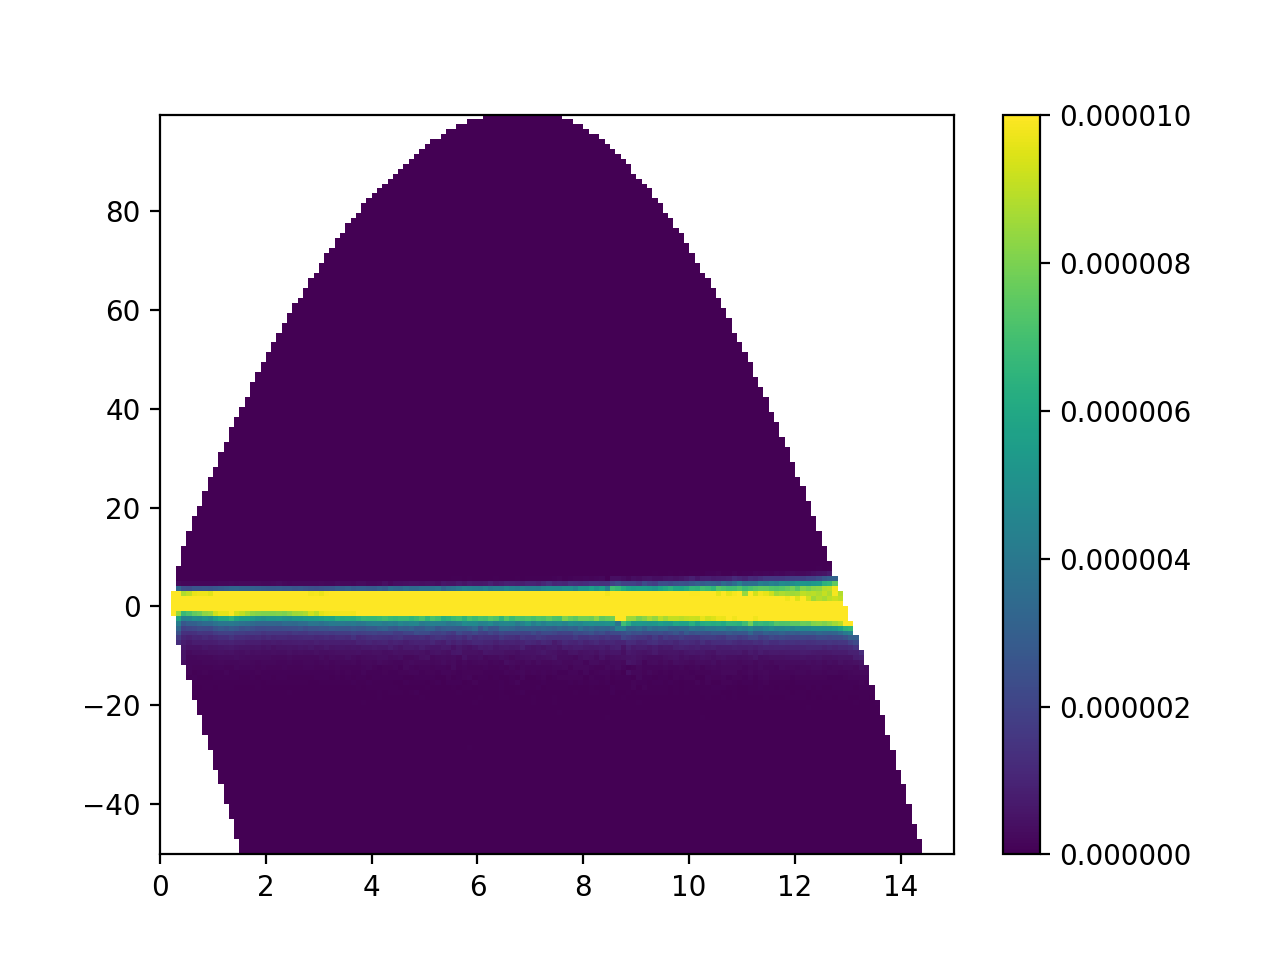

In [9]:
import histogram as H
%matplotlib notebook
H.plot(iqe, min=0, max=1e-5)

In [10]:
iq = iqe[(), (-5,5)].sum('E')

<IPython.core.display.Javascript object>


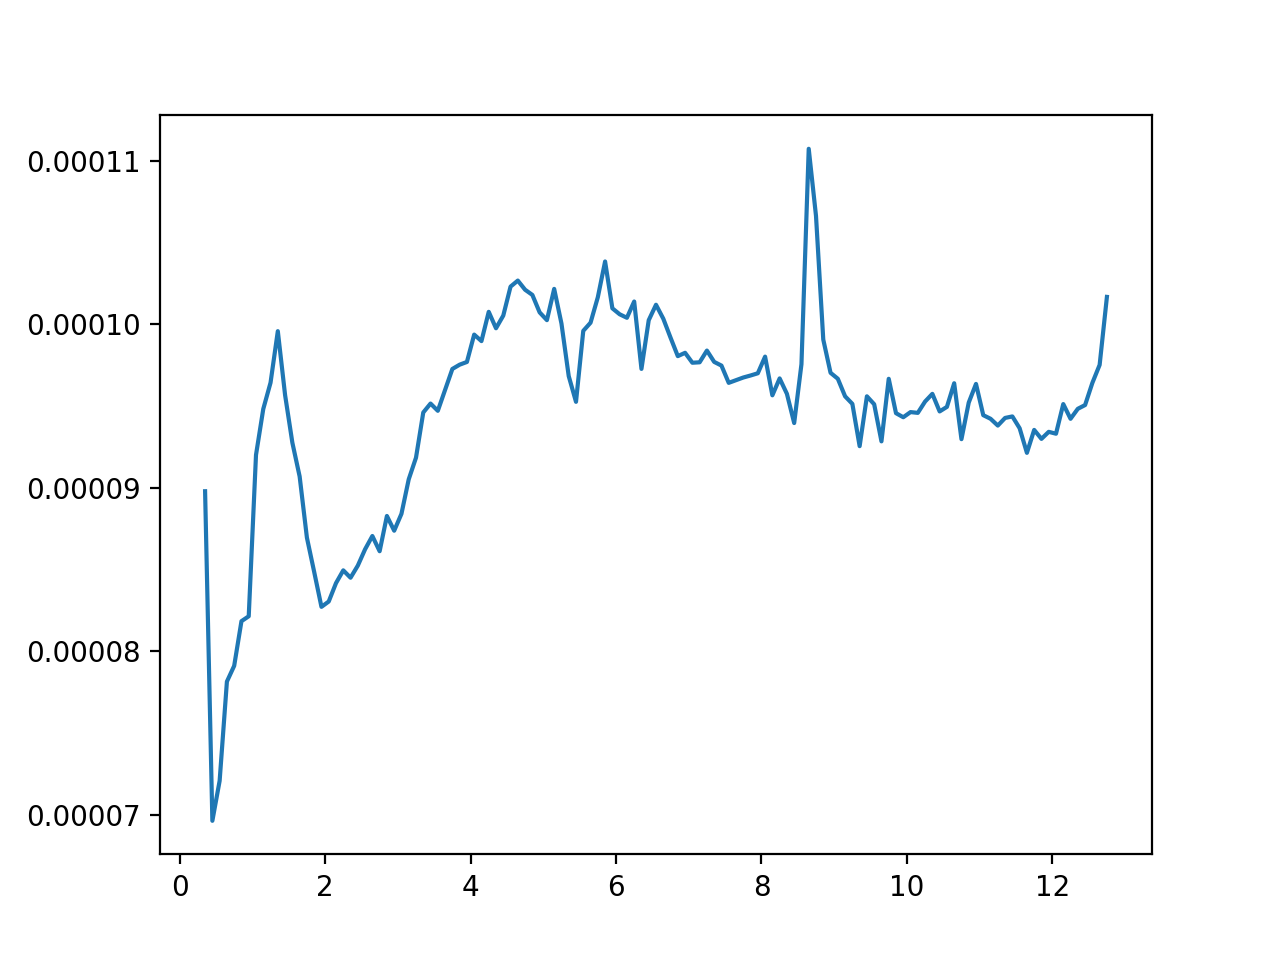

In [13]:
plt.figure()
plt.plot(iq.Q, iq.I)
plt.show()

The I(Q) curve does not have a linear increasing correlation of Q because it is normalized by solid angle (not perfectly but counting every pixel as the same solid angle size).